# 2nd-place-solution

Our solution works as follows:
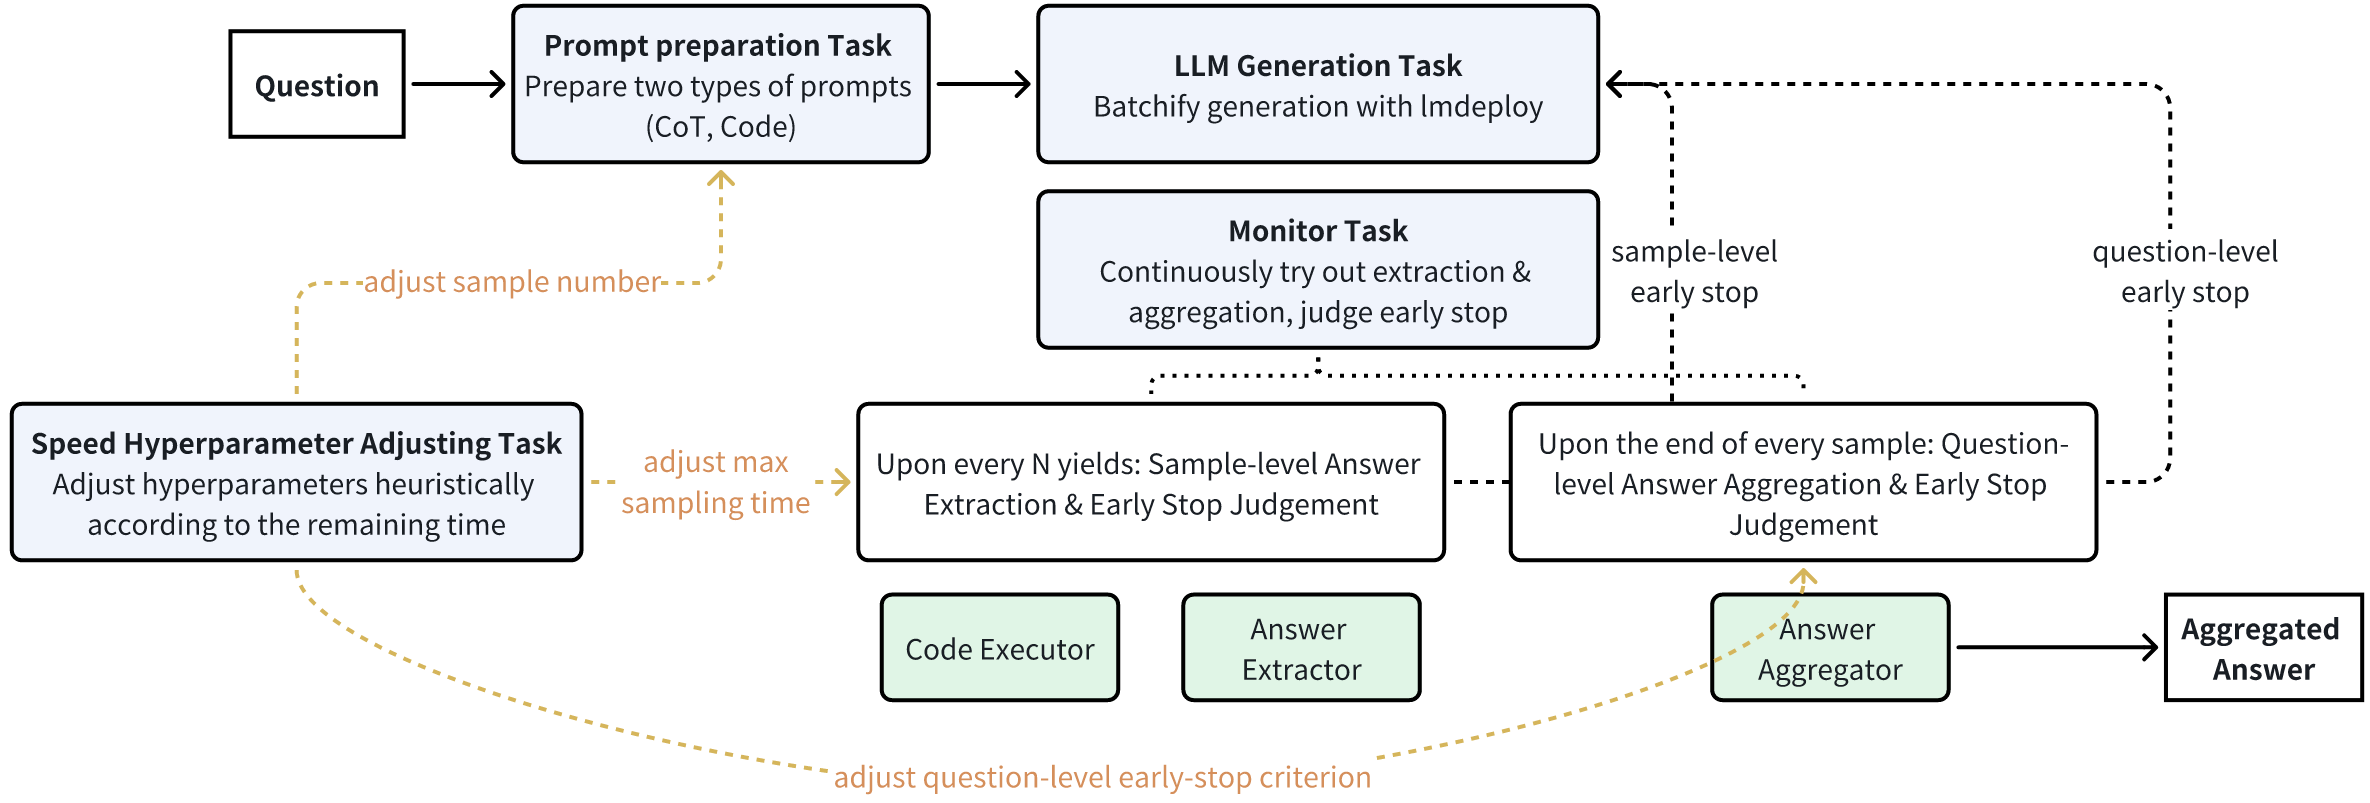

## Setup and imports

In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
import sys
sys.path.append('/kaggle/input/lmdeploy-package')
import re
import time
import json
import math
import queue
import random
import logging
import argparse
import threading
import subprocess
import tempfile
import shutil
import asyncio
import yaml
import numpy as np
import torch
from transformers import set_seed
import pandas as pd
import polars as pl
from collections import OrderedDict
from typing import List, Tuple, Dict, Any
from lmdeploy import pipeline, TurbomindEngineConfig, GenerationConfig
import kaggle_evaluation.aimo_2_inference_server 

random_seed = int(time.time()) % 10000
set_seed(random_seed)
global_cutoff_time = time.time() + (4 * 60 + 57) * 60
global_start_time = time.time()

# add new path for pythonpath
original_pythonpath = os.environ.get("PYTHONPATH", "")
new_path = "/kaggle/input/lmdeploy-package"
merged_pythonpath = f"{new_path}:{original_pythonpath}" if original_pythonpath else new_path
os.environ["PYTHONPATH"] = merged_pythonpath
# Configure environment and settings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['PYTHONUNBUFFERED'] = '1'
pd.set_option('display.max_colwidth', None)

## Configuration
Here contains all the main configs we use in this solution

In [2]:
config = {
        "main_model": {
            "model_cfg":{
                "model_path": "/kaggle/input/dpsk-14b-sft-dpo-3-13-awq-tb/keras/default/1/dpsk-14b-sft-dpo4-3-13-awq-tb",
                "gpu_indices": [0,1,2,3],           
            },
            "inference_cfg": {
                "max_batch_size": 20,
                "quant_policy": 8,
                "enable_prefix_caching": True,
                "cache_max_entry_count": 0.97,
                "max_prefill_token_num": 8192,
                "gen_max_new_tokens": 25000
            }
        },
        "actor": {
            "actor_cls": "EarlyStopActor",
            "model_dict":{
                "main_model": "main_model"
            },
            "prompt_list_combine": "interleave",
            "prompt_list": [
                {
                    "system": "You are a helpful math assistant. Please reason step by step to put the answer in \\boxed{}.",
                    "user_suffix": "\nYou excel at reasoning.\nYou must put the final answer in \\boxed{}.\nIf the final answer is greater than 1000, then take the modulo of 1000.\nThink carefully and thoroughly, avoid duplication.",
                    "number": 10
                },
                {
                    "system": "You are a helpful math assistant. Please provide the python code to solve the math problem and also put the final answer in \\boxed{}.",
                    "user_suffix": "\nYou excel at coding\nYou must provide the python code, avoid redundant analysis.\nIf the final answer is greater than 1000, then take the modulo of 1000.\nThe answer must be integer.\nThere is only one answer for each question.\nImport necessary libraries.\n Improve efficiency, avoid too many loop nesting",
                    "number": 10
                }
            ],
            "gen_cfg": {
                "temperature": 0.9,
                "min_p": 0.1,
                "skip_special_tokens": True,
                "max_new_tokens": 20000,
                "top_p": 0.95,
                "do_sample": True,
                "repetition_penalty": 1.05,
            }
        },
        "early_stop_strategy": {
            "every_n": 20,                # check every 20 steps

            # consistency_rules:
            "consistency_rules": [
                # 4 repeated in 4
                {"max_answers": 4, "min_repeats": 4, "message": "An answer repeated 4 times in less than 4 valid answers."},
                # 4 repeated in 5
                {"recent": 5, "min_repeats": 4, "message": "An answer repeated 4 times in recent 5 valid answers."},
                # 5 repeated in 7
                {"max_answers": 7, "min_repeats": 5, "message": "An answer repeated 5 times in less than 7 valid answers."},
                # 6 repeated in 9
                {"max_answers": 9, "min_repeats": 6, "message": "An answer repeated 6 times in less than 9 valid answers."}
            ],
            
            # adjust_speed:
            "speed_settings": {
                "very_fast": {
                    "min_answers": 8,
                    "timeout_minutes": 9,
                    "early_timeouts": [
                        {"time": 6, "min_answers": 6},
                        {"time": 7, "min_answers": 4},
                        {"time": 8, "min_answers": 3}
                    ]
                },
                "fast": {
                    "min_answers": 10,
                    "timeout_minutes": 9,
                    "early_timeouts": [
                        {"time": 6.5, "min_answers": 6},
                        {"time": 7.5, "min_answers": 5},
                        {"time": 8.5, "min_answers": 4}
                    ]
                },
                "normal": {
                    "min_answers": 11,
                    "timeout_minutes": 10,
                    "early_timeouts": [
                        {"time": 7, "min_answers": 7},
                        {"time": 8, "min_answers": 6},
                        {"time": 9, "min_answers": 5}
                    ]
                },
                "slow": {
                    "min_answers": 12,
                    "timeout_minutes": 11,
                    "early_timeouts": [
                        {"time": 9, "min_answers": 6},
                        {"time": 10, "min_answers": 5}
                    ]
                },
                "very_slow": {
                    "min_answers": 13,
                    "timeout_minutes": 11,
                    "early_timeouts": [
                        {"time": 9, "min_answers": 6},
                        {"time": 10, "min_answers": 5}
                    ]
                }
            }
        },
        "exam_dataset_files": "/kaggle/input/ai-mathematical-olympiad-progress-prize-2/reference.csv",
        "output_path": "results",
        "use_server_for_eval": True,
        "callback_every_fast_forward": False,
    }

## Extractor and PythonREPL


In [3]:
class AnswerExtractor:
    @staticmethod
    def extract_python_code(text: str) -> List[str]:
        pattern = r"```python\s*(.*?)\s*```"
        matches = re.findall(pattern, text, re.DOTALL)
        return [matches[-1]] if matches else []

    @staticmethod
    def process_python_code(query: str) -> Tuple[str, int]:
        query = "import math\nimport numpy as np\nimport sympy as sp\n" + query
        current_rows = query.strip().split("\n")
        new_rows = []
        new_rows_codes = []

        for row in current_rows:
            stripped_row = row.strip()
            new_rows.append(row)
            if stripped_row and not stripped_row.startswith("#"):
                new_rows_codes.append(stripped_row)

        ans = "\n".join(new_rows)
        return ans

    @staticmethod
    def extract_boxed_text(text: str) -> int:
        pattern = r"oxed{(.*?)}"
        matches = re.findall(pattern, text)
        if matches:
            return AnswerExtractor.canonicalize_number(matches[-1])
        return None

    @staticmethod
    def canonicalize_number(content: str) -> int:
        try:
            num = int(content)
            return num % 1000
        except ValueError:
            try:
                # try to convert it to int
                num = int(float(content))
                if math.isinf(num):
                    print(f"Parsed infinite value from {content}.")
                return num % 1000
            except (ValueError, OverflowError):
                return None


class PythonREPL:
    """Python code execution environment"""

    def __init__(self, timeout=20):
        self.timeout = timeout

    def __call__(self, query: str) -> Tuple[bool, str]:
        with tempfile.TemporaryDirectory() as temp_dir:
            temp_file_path = os.path.join(temp_dir, "tmp.py")
            with open(temp_file_path, "w", encoding="utf-8") as f:
                f.write(query)

            try:
                result = subprocess.run(
                    ["python3", temp_file_path],
                    capture_output=True,
                    check=False,
                    text=True,
                    timeout=self.timeout,
                )
            except subprocess.TimeoutExpired:
                return False, f"Execution timed out after {self.timeout} seconds."

            stdout = result.stdout.strip()
            stderr = result.stderr.strip()

            if result.returncode == 0:
                return True, stdout
            else:
                # Process the error message to remove the temporary file path
                error_lines = stderr.split("\n")
                cleaned_errors = []
                for line in error_lines:
                    if temp_file_path in line:
                        # Remove the path from the error line
                        line = line.replace(temp_file_path, "<temporary_file>")
                    cleaned_errors.append(line)
                cleaned_error_msg = "\n".join(cleaned_errors)
                # Include stdout in the error case
                combined_output = (
                    f"{stdout}\n{cleaned_error_msg}" if stdout else cleaned_error_msg
                )
                return False, combined_output



## Model initialization

In [4]:
class PipedModel:
    def __init__(self, model_cfg, inference_cfg):
        # Set visible GPUs based on gpu_indices configuration
        gpu_indices = model_cfg.get('gpu_indices', None)
        
        if gpu_indices:
            # If specific GPUs are requested, use only those
            import os
            os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, gpu_indices))
            num_gpus = len(gpu_indices)
        else:
            # If no specific GPUs are requested, use all available GPUs
            num_gpus = torch.cuda.device_count()

        self.model_path = model_cfg["model_path"]
        self.backend = "turbomind"
        self.backend_config = TurbomindEngineConfig(
            tp=num_gpus,
            session_len=inference_cfg.pop("gen_max_new_tokens")
            + inference_cfg["max_prefill_token_num"]
            + 128,
            **inference_cfg,
        )
        self.pipe = pipeline(self.model_path, self.backend_config)

    def __getattr__(self, name):
        return getattr(self.pipe, name)
    
    def _stop_all_sessions(self, start, size):
        """Helper method to stop all active generation sessions"""
        try:
            # Try the synchronous approach first
            asyncio.run(self._stop_sessions(start, size))
        except Exception as e:
            print(f"Error stopping sessions: {e}")

    def _stop_one_session(self, session_id):
        """Helper method to stop a single model session"""
        try:
            # Try the synchronous approach first
            asyncio.run(self._stop_session(session_id))
        except Exception as e:
            print(f"Error stopping session {session_id}: {e}")

    async def _stop_sessions(self, start, size):
        """Helper method to stop model sessions"""
        for i in range(start, start + size):
            await self.pipe.stop_session(i + 1)

    async def _stop_session(self, session_id):
        """Helper method to stop a single model session"""
        await self.pipe.stop_session(session_id + 1)

## Aggregator

In [5]:
from collections import Counter, defaultdict

class AnswerPriorityVoteMajorityAggregator:
    def __init__(
        self, priority="code", highp_weight=1, lowp_pos_weight=1, lowp_neg_weight=0
    ):
        self.priority = priority
        assert self.priority in {"code", "cot"}
        self.highp_weight = highp_weight
        # the weight of the lower-priority answer when the higher-priority answer doesn't exist
        self.lowp_pos_weight = lowp_pos_weight
        # the weight of the lower-priority answer when the higher-priority answer exists
        self.lowp_neg_weight = lowp_neg_weight

    def aggregate_answer(self, cot_answers, code_answers) -> int:
        final_code_answers = [
            list(dct.values())[-1] if dct else None for dct in code_answers
        ]
        final_cot_answers = [
            list(dct.values())[-1] if dct else None for dct in cot_answers
        ]
        answers_and_weights = []
        for code_ans, cot_ans in zip(final_code_answers, final_cot_answers):
            if self.priority == "code":
                if code_ans is not None:
                    answers_and_weights += [
                        (code_ans, self.highp_weight),
                        (cot_ans, self.lowp_neg_weight),
                    ]
                else:
                    answers_and_weights += [(cot_ans, self.lowp_pos_weight)]
            else:  # cot priority
                if cot_ans is not None:
                    answers_and_weights += [
                        (cot_ans, self.highp_weight),
                        (code_ans, self.lowp_neg_weight),
                    ]
                else:
                    answers_and_weights += [(code_ans, self.lowp_pos_weight)]
        aggregated_answers_and_weights = defaultdict(lambda: 0.0)
        for ans, weight in answers_and_weights:
            if ans is None:
                continue
            aggregated_answers_and_weights[ans] += weight

        if not aggregated_answers_and_weights:
            return -1

        # Get the answer with the highest weight
        aggregated_answer = sorted(
            aggregated_answers_and_weights.items(), key=lambda item: -item[1]
        )[0][0]
        return aggregated_answer % 1000


class AllVoteMajorityAggregator:
    @staticmethod
    def aggregate_answer(cot_answers, code_answers) -> int:
        final_code_answers = [
            list(dct.values())[-1] if dct else None for dct in code_answers
        ]
        final_cot_answers = [
            list(dct.values())[-1] if dct else None for dct in cot_answers
        ]
        # Just use all answers to do the vote
        # TODO: if code/cot & outputs length is related to the overall correct ratio.
        # can add some weighting strategy here
        valid_answers = [
            int(ans)
            for ans in final_code_answers + final_cot_answers
            if ans is not None and int(ans) >= 0
        ]
        if not valid_answers:
            return 49
        # New weighting strategy
        weighted_answers = defaultdict(float)
        
        for answer in valid_answers:
            # Default weight is 1.0
            weight = 1.0
            
            # Apply 0.6 weight for answers < 20 or answers that are multiples of 100
            if answer <= 20 or answer % 100 == 0:
                weight = 0.6
                
            weighted_answers[answer] += weight
        
        # Get the answer with the highest weight
        # When weights are equal, prefer the larger answer
        aggregated_answer = sorted(
            weighted_answers.items(), key=lambda item: (-item[1], -item[0])
        )[0][0]
        
        return aggregated_answer % 1000


## BasicActor

In [6]:
class BasicActor:
    def __init__(
        self,
        cfg,
        model_dict,
        gen_cfg,
        prompt_list,
        prompt_list_combine="interleave",
        common_prompt=None,
        answer_extractor=None,
        answer_aggretor=None,
        callback_every_fast_forward=False,
    ):
        # Prepare models
        self._init_models(model_dict, cfg)
        self._model_dict_cfg = model_dict

        # use "number" in each item in the `prompt_list` configuration to configure number of samples w. that prompt

        # Prepare generation config
        self.gen_config = GenerationConfig(**gen_cfg)

        # Initialize Python executor, answer's extractor and aggregator
        # TODO: let's see what we need to configure for these
        self.python_executor = PythonREPL()
        self.answer_extractor = AnswerExtractor()
        self.answer_aggregator = AllVoteMajorityAggregator()

        # Prepare callbacks for `stream_generate`
        self.callbacks = [
            {"upon": "finish stop", "function": self._callback_extract_answer},
            {"upon": "finish length", "function": self._callback_extract_answer},
            # for testing `callback_every_fast_forward`
            # {"upon": "every 100", "function": self._callback_log_index_and_response}
        ]
        self.callback_every_fast_forward = callback_every_fast_forward

        # Maintain time
        self.total_time = 0.0
        self.initialized_time = (
            time.time()
        )  # record the current time, for potential early stop strategy based on cutoff time

        # Add speed adjustment variables
        self.TOTAL_QUESTIONS = 50
        self.CHECK_AFTER_QUESTIONS = 20  # First check after 30 questions
        self.CHECK_INTERVAL = 2         # Then check every 2 questions
        self.TIME_THRESHOLDS = {
            (0, 300): 1,            # < 5:00 - very fast (speed=1)
            (300, 345): 2,          # 5:00-5:45 - fast (speed=2) 
            (345, 370): 3,          # 5:45-6:10 - normal (speed=3)
            (370, 420): 4,          # 6:10-7:00 - slow (speed=4)
            (420, float('inf')): 5  # > 7:00 - very slow (speed=5)
        }
        self.SPEED_TO_SAMPLES = {
            1: 10,   # Very fast - use fewer samples
            2: 12,   # Fast
            3: 15,  # Normal
            4: 16,  # Slow
            5: 17   # Very slow - use more samples
        }
        self.current_speed = 3  # Default to normal speed
        self.current_target_samples = self.SPEED_TO_SAMPLES[self.current_speed]
        self.cutoff_time = global_cutoff_time  # Default 1 hour cutoff
        self.g_count = 0  # Question counter
        # Prepare prompt list
        self.initial_prompt_struct = self._init_prompts( # Store the structure for potential regeneration
            prompt_list, prompt_list_combine, common_prompt
        )
        self._update_active_prompts()

    @staticmethod
    def _init_prompts(prompt_list, prompt_list_combine, common_prompt):
        assert prompt_list_combine in {"concat", "random", "interleave"}
        common_prompt = common_prompt or {
            "system": "",
            "user_prefix": "",
            "user_suffix": "",
        }
        
        # Create expanded prompt lists with their sample types
        prompt_expand_lists = []
        for prompt_choice in prompt_list:
            system_prompt = common_prompt.get("system", "") + prompt_choice.get("system", "")
            user_prefix = common_prompt.get("user_prefix", "") + prompt_choice.get("user_prefix", "")
            user_suffix = prompt_choice.get("user_suffix", "") + common_prompt.get("user_suffix", "")
            
            # Determine if this is a code sample based on the system prompt
            is_code_sample = "python code" in system_prompt.lower() or "code" in system_prompt.lower()
            
            prompt_expand_lists.append(
                [(system_prompt, user_prefix, user_suffix, is_code_sample)] * prompt_choice.get("number", 1)
            )
        
        if prompt_list_combine == "concat":
            prompt_list = sum(prompt_expand_lists, [])
        elif prompt_list_combine == "random":
            prompt_list = sum(prompt_expand_lists, [])
            random.shuffle(prompt_list)
        else:  # interleave
            # Interleave the prompts from different categories
            prompt_list = []
            max_len = max(len(single_list) for single_list in prompt_expand_lists)
            for i in range(max_len):
                for single_list in prompt_expand_lists:
                    if i < len(single_list):
                        prompt_list.append(single_list[i])
        
        return prompt_list

    def _init_models(self, model_dict, cfg):
        for attr_name, cfg_key_name in model_dict.items():
            model_pipe = PipedModel(**cfg[cfg_key_name])
            setattr(self, attr_name, model_pipe)

    def _update_active_prompts(self):
        """Selects prompts based on current_target_samples and strategy."""
        # FIX for Speed Adjustment Bug: Select a subset of initial prompts based on target count.
        total_initial_prompts = len(self.initial_prompt_struct)
        if self.current_target_samples >= total_initial_prompts:
            # Use all available initial prompts if target is high enough
            self.prompt_list = self.initial_prompt_struct
        else:
            # Select a subset.
            self.prompt_list = self.initial_prompt_struct[:self.current_target_samples]

        self.num_samples = len(self.prompt_list)
        print(f"Updated active prompts. Target: {self.current_target_samples}, Actual: {self.num_samples}")

    def adjust_speed(self):
        """Adjust speed based on progress through questions"""
        # Only check at specific question counts
        if (self.g_count >= self.CHECK_AFTER_QUESTIONS and self.g_count < self.TOTAL_QUESTIONS and self.g_count % self.CHECK_INTERVAL == 0):
            
            # Calculate average time per question
            avg_time_remain = (self.cutoff_time - time.time()) / (self.TOTAL_QUESTIONS - self.g_count)
            
            # Determine new speed based on estimated time
            new_speed = 3  # Default
            for time_range, speed_value in self.TIME_THRESHOLDS.items():
                if time_range[0] <= avg_time_remain < time_range[1]:
                    new_speed = speed_value
                    break
            
            # Update speed if it changed
            if new_speed != self.current_speed:
                old_speed = self.current_speed
                self.current_speed = new_speed
                
                # Update sample count based on new speed
                self.current_target_samples = self.SPEED_TO_SAMPLES[new_speed]
                self._update_active_prompts() 
                
                print(f"[SPEED ADJUSTMENT] After {self.g_count} questions: remaining avg time: {avg_time_remain:.2f} seconds")
                print(f"[SPEED ADJUSTMENT] Changed speed from {old_speed} to {new_speed}, num_samples={self.current_target_samples}")
                
                return True
                
        return False

    def predict_for_question(self, question: str, id_=None) -> int:
        """Predict answer for a single question"""

        # Reset early stopping state
        self.question_start_time = time.time()
        self.valid_answers = []
        self.consistency_stop_triggered = False
        if time.time() > self.cutoff_time:
            return 210
        
        print(f"\n{'='*80}")
        print(f"QUESTION {self.g_count}: ID={id_}")
        print(f"Speed mode: {self.current_speed} ({self.current_target_samples} samples)")
        print(f"Question: {question}")
        print(f"{'='*80}\n")
        
        # adjust speed
        self.adjust_speed()

        prompts = [
            [
                {"role": "system", "content": system},
                {"role": "user", "content": user_prefix + question + user_suffix},
            ]
            for system, user_prefix, user_suffix, _ in self.prompt_list
        ]

        # Generate and process model outputs
        (
            cot_answers,
            code_answers,
            out_lens,
            python_code_map_list,
            code_exec_error_map_list,
            outputs,
        ) = self.stream_generate(prompts, self.gen_config, self.callbacks)

        # Filter CoT answers if code answers exist
        filtered_cot_answers = []
        for idx, (cot_ans, code_ans) in enumerate(zip(cot_answers, code_answers)):
            filtered_cot = OrderedDict()
            if cot_ans and code_ans:
                print(f"[Sample {idx+1}] Both CoT and code answers exist. Using only code answer.")
                filtered_cot = OrderedDict()  
            else:
                filtered_cot = cot_ans
            filtered_cot_answers.append(filtered_cot)

        # Combine and select final answer
        aggregated_answer = self.answer_aggregator.aggregate_answer(
            filtered_cot_answers, code_answers
        )

        self.g_count += 1

        # Print debugging information
        print(f"\n{'='*30} QUESTION SUMMARY {'='*30}")
        print(f"CoT answers: {[list(ans.values())[-1] if ans else None for ans in cot_answers]}")
        print(f"Code answers: {[list(ans.values())[-1] if ans else None for ans in code_answers]}")
        print(f"Final aggregated answer: {aggregated_answer}")

        # Calculate and store timing information
        question_duration = time.time() - self.question_start_time
        self.total_time += question_duration
        
        # Print timing information
        print(f"Question {id_} solving time: {question_duration:.2f} seconds")
        print(f"Total solving time so far: {self.total_time:.2f} seconds")
        print(f"{'='*80}\n")

        return aggregated_answer

    def stream_generate(self, prompts, gen_config, callbacks):
        # Setup answer's store
        num_prompts = len(prompts)
        print(f"\n{'='*30}\nStarting generation with {num_prompts} samples\n{'='*30}")
        sample_start_times = [time.time()] * num_prompts

        outputs = [""] * num_prompts  # Store complete output for each prompt
        token_counts = [0] * num_prompts  # Store token count for each prompt
        yield_counts = [0] * num_prompts  # Store yield count for each prompt
        completed_status = [
            False
        ] * num_prompts  # Flag to mark if each prompt is completed naturally

        # The answer got by match \\bbox.
        # The dict is a mapping FROM the token count when parsing TO the last parsed boxed answer
        cot_answers = [OrderedDict() for _ in range(num_prompts)]
        # The answer got by parsing and executing code.
        # The dict is a mapping FROM the token count when parsing TO the last parsed python code
        code_answers = [OrderedDict() for _ in range(num_prompts)]
        # The Python code parsed.
        # The dict is a mapping FROM the token count when parsing TO the last parsed python code
        python_code_map_list = [OrderedDict() for _ in range(num_prompts)]
        # Python code execution errors.
        # The dict is a mapping FROM token count when parsing TO the execution error string
        code_exec_error_map_list = [OrderedDict() for _ in range(num_prompts)]

        # Group callback functions by criteria
        callbacks_on_finish = [
            (
                re.match("finish (.+)", callback_item["upon"]).group(1),
                callback_item["function"],
            )
            for callback_item in self.callbacks
            if callback_item["upon"].startswith("finish")
        ]
        callbacks_every_n = [
            (
                int(re.match(r"every (\d+)", callback_item["upon"]).group(1)),
                callback_item["function"],
            )
            for callback_item in self.callbacks
            if callback_item["upon"].startswith("every")
        ]
        if callbacks_every_n and self.callback_every_fast_forward:
            last_callback_yield_counts = [
                [0] * num_prompts for _ in range(len(callbacks_every_n))
            ]

        session_id_start = next(self.main_model.pipe._session_id)
        iterator = self.main_model.stream_infer(prompts, gen_config)

        for response in iterator:
            try:
                index = response.index if response is not None else 0
                token_counts[index] = response.generate_token_len
                yield_counts[index] += 1
                if response.text is not None:
                    outputs[index] += response.text
                    # Call callback functions
                for _every_n, callback_func in callbacks_every_n:
                    if yield_counts[index] % _every_n == 0:
                        callback_func(
                            index,
                            session_id_start,
                            self.current_target_samples,
                            outputs,
                            cot_answers,
                            code_answers,
                            token_counts,
                            python_code_map_list,
                            code_exec_error_map_list,
                            self.main_model,
                            response,
                            completed_status,
                        )
                if response.finish_reason is not None:
                    if completed_status[index]:
                        continue
                    completed_status[index] = True
                    end_time = time.time()
                    elapsed = end_time - sample_start_times[index]
                    tokens_per_sec = token_counts[index] / elapsed if elapsed > 0 else 0
                    
                    for callback_finish_reason, callback_func in callbacks_on_finish:
                        if callback_finish_reason == response.finish_reason:
                            callback_func(
                                index,
                                session_id_start,
                                self.current_target_samples,
                                outputs,
                                cot_answers,
                                code_answers,
                                token_counts,
                                python_code_map_list,
                                code_exec_error_map_list,
                                self.main_model,
                                response,
                                completed_status,
                            )
                    # Show current answers for this sample
                    cot_ans = list(cot_answers[index].values())[-1] if cot_answers[index] else None
                    code_ans = list(code_answers[index].values())[-1] if code_answers[index] else None
                    print(f"[COMPLETE] Sample {index+1} finished reason '{response.finish_reason}'- CoT: {cot_ans}, Code: {code_ans} | Speed: {tokens_per_sec:.2f} t/s")
                        
            except Exception as e:
                # Handle case where response or its attributes might be None
                print(f"[Warning]: Error processing response: {e}", flush=True)
                continue

        return (
            cot_answers,
            code_answers,
            token_counts,
            python_code_map_list,
            code_exec_error_map_list,
            outputs,
        )

    ## ----- The answer parsing callback ----
    def _callback_extract_answer(
        self,
        index,
        session_id_start,
        current_target_samples,
        outputs,
        cot_answers,
        code_answers,
        token_counts,
        python_code_map_list,
        code_exec_error_map_list,
        model,
        response,
        completed_status: List[bool]
    ):
        """Try to parse the cot & code answers and populate into the lists."""
        try:
            cur_token_count = token_counts[index]
            
            # Original processing code continues normally
            # Try to process cot output
            cot_answer = self._try_parse_boxed_answer(outputs[index])
            if cot_answer:
                old_answer = list(cot_answers[index].values())[-1] if cot_answers[index] else None
                self._update_map_when_different_from_the_last(
                    cot_answers[index], cur_token_count, cot_answer
                )
                if cot_answer != old_answer:
                    print(f"[Sample {index+1}] New CoT answer: {cot_answer} | Tokens: {cur_token_count} ")

            # Try to get previous code
            previous_code = None
            if python_code_map_list[index]:
                previous_code = list(python_code_map_list[index].values())[-1]
                
            # Try to process code output
            code_answer, code_exec_error, python_code = self._try_parse_code_answer(
                outputs[index], previous_code
            )
            if python_code and python_code != previous_code:
                # update python code 
                python_code_map_list[index][cur_token_count] = python_code
                # update code error
                if code_exec_error is not None:
                    code_exec_error_map_list[index][cur_token_count] = code_exec_error
                if code_answer is not None:
                    self._update_map_when_different_from_the_last(
                        code_answers[index], cur_token_count, code_answer
                    )
                    
                    if code_answer >= 0:
                        print(
                            f"[Sample {index+1}] New Code answer: {code_answer} | Tokens:"
                            f" {cur_token_count} "
                        )
                    else:
                        print(
                            f"[Sample {index+1}] Code error: {code_exec_error} | Tokens:"
                            f" {cur_token_count} "
                        )
                    
        except Exception as e:
            print(f"Error in extract answer callback for index {index}: {e}")


    def _try_parse_boxed_answer(self, text):
        return self.answer_extractor.extract_boxed_text(text)

    def _try_parse_code_answer(self, text, previous_code):
        answer, code_exec_error, python_code = None, None, None
        try:
            # extract python code
            python_codes = self.answer_extractor.extract_python_code(text)
            if python_codes:
                python_code = self.answer_extractor.process_python_code(python_codes[-1])
                if previous_code == python_code:
                    return None, None, python_code
                    
                exec_success, exec_output = self.python_executor(python_code)
                if exec_success:
                    pattern = r"(\d+)(?:\.\d+)?"
                    matches = re.findall(pattern, exec_output)
                    if matches:
                        answer = self.answer_extractor.canonicalize_number(matches[-1])
                else:
                    code_exec_error = exec_output
                    answer = -1
        except Exception as e:
            print(f"Error parsing code answer: {e}")
            code_exec_error = str(e)
            answer = -1
        return answer, code_exec_error, python_code

    @staticmethod
    def _update_map_when_different_from_the_last(map_, cur_token_count, new_value):
        if (not map_ or list(map_.values())[-1] != new_value) and new_value is not None:
            map_[cur_token_count] = new_value

## EarlyStopActor

In [7]:
class EarlyStopActor(BasicActor):
    def __init__(
        self,
        cfg,
        model_dict,
        gen_cfg,
        prompt_list,
        prompt_list_combine="concat",
        common_prompt=None,
        answer_extractor=None,
        answer_aggretor=None,
        early_stop_strategy=None,
        callback_every_fast_forward=False,
    ):
        super().__init__(
            cfg,
            model_dict,
            gen_cfg,
            prompt_list,
            prompt_list_combine,
            common_prompt,
            answer_extractor,
            answer_aggretor,
            callback_every_fast_forward,
        )
        self.early_stop_strategy = early_stop_strategy or {}
        self.consistency_stop_triggered = False
        self.every_n = self.early_stop_strategy.get("every_n", 100)
        # Add the callbacks
        self.callbacks=[
            {"upon": "finish length", "function": self._callback_extract_answer},
            {"upon": "finish stop", "function": self._callback_extract_answer},
            {"upon": "finish stop", "function": self._stop_for_consistency},
            {"upon": f"every {self.every_n}", "function": self._stop_for_finding_answer},
            {"upon": f"every {self.every_n}", "function": self._stop_for_consistency},
            {"upon": f"every {self.every_n}", "function": self._stop_for_timeout},
        ]
        
        # Tracking variables for early stopping
        self.question_start_time = None
        self.valid_answers = []
        # Get consistency rules and speed settings
        self.consistency_rules = self.early_stop_strategy.get("consistency_rules", [])
        self.speed_settings = self.early_stop_strategy.get("speed_settings", {})

    def _stop_for_consistency(
        self,
        index,
        session_id_start,
        current_target_samples,
        outputs,
        cot_answers,
        code_answers,
        token_counts,
        python_code_map_list,
        code_exec_error_map_list,
        model: PipedModel,
        response,
        completed_status: List[bool]
    ):
        """Determine whether to stop generation based on configured consistency rules"""
        try:
            if self.consistency_stop_triggered:
                return False
                
            # collect valid answers
            self.valid_answers = []
            for idx, (cot_ans, code_ans) in enumerate(zip(cot_answers, code_answers)):
                if code_ans:  
                    last_code_answer = list(code_ans.values())[-1]
                    if last_code_answer is not None and last_code_answer >= 0:
                        self.valid_answers.append(last_code_answer)
                elif cot_ans:  
                    last_cot_answer = list(cot_ans.values())[-1]
                    if last_cot_answer is not None and last_cot_answer >= 0:
                        self.valid_answers.append(last_cot_answer)
            
            for rule in self.consistency_rules:
                if "recent" in rule:
                    n_recent = rule["recent"]
                    min_repeats = rule["min_repeats"]
                    message = rule.get("message", f"An answer repeated {min_repeats} times in recent {n_recent} answers.")
                    
                    if len(self.valid_answers) >= n_recent:
                        recent_answers = self.valid_answers[-n_recent:]
                        if any(recent_answers.count(x) >= min_repeats for x in set(recent_answers)):
                            print(f"[End]: {message}",flush=True)
                            model._stop_all_sessions(session_id_start, current_target_samples+2)
                            self.consistency_stop_triggered = True
                            return True
                
                # Check for repetitions in fewer than N answers
                elif "max_answers" in rule:
                    max_answers = rule["max_answers"]
                    min_repeats = rule["min_repeats"]
                    message = rule.get("message", f"An answer repeated {min_repeats} times in less than {max_answers} valid answers.")
                    
                    if len(self.valid_answers) <= max_answers and any(self.valid_answers.count(x) >= min_repeats for x in set(self.valid_answers)):
                        print(f"[End]: {message}",flush=True)
                        model._stop_all_sessions(session_id_start, current_target_samples+2)
                        self.consistency_stop_triggered = True
                        return True
            
            # Get settings for current speed
            speed_key = {
                1: "very_fast",
                2: "fast", 
                3: "normal",
                4: "slow",
                5: "very_slow"
            }.get(self.current_speed, "normal")
            
            speed_config = self.speed_settings.get(speed_key, {})
            min_answers = speed_config.get("min_answers", 8)  # Default value is 8
            
            # Check answer count based on speed
            if len(self.valid_answers) >= min_answers:
                print(f"\n[EARLY STOP TRIGGERED] Collected {len(self.valid_answers)} answers (speed={self.current_speed}).", flush=True)
                model._stop_all_sessions(session_id_start, current_target_samples+2)
                self.consistency_stop_triggered = True
                return True
            
        except Exception as e:
            LOGGER.error(f"Error in consistency check: {e}")
            return False

    def _stop_for_timeout(
        self,
        index,
        session_id_start,
        current_target_samples,
        outputs,
        cot_answers,
        code_answers,
        token_counts,
        python_code_map_list,
        code_exec_error_map_list,
        model: PipedModel,
        response,
        completed_status: List[bool]
    ):
        """Check if generation should timeout based on timeout strategy"""
        if self.question_start_time is None:
            return False  # Cannot check timeout without a start time
            
        solve_time = time.time()
        solved_time = solve_time - self.question_start_time
        
        # Build list of valid answers (if not already built)
        if not hasattr(self, 'valid_answers') or len(self.valid_answers) == 0:
            self.valid_answers = []
            for ans_list in cot_answers + code_answers:
                if ans_list:
                    for ans in ans_list.values():
                        if ans is not None and ans >= 0 :
                            self.valid_answers.append(ans)
        
        # Get settings for current speed
        speed_key = {
            1: "very_fast",
            2: "fast", 
            3: "normal",
            4: "slow",
            5: "very_slow"
        }.get(self.current_speed, "normal")
        
        speed_config = self.speed_settings.get(speed_key, {})
        timeout_minutes = speed_config.get("timeout_minutes", 10)  # Default 10 minutes
        early_timeouts = speed_config.get("early_timeouts", [])
        
        # Check early timeout conditions
        for timeout_rule in early_timeouts:
            time_threshold = timeout_rule.get("time", 10) * 60  # Convert to seconds
            min_answers = timeout_rule.get("min_answers", 8)
            
            if solved_time > time_threshold and len(self.valid_answers) >= min_answers:
                print(f"[End] {speed_key.replace('_', ' ').title()} mode time out with {min_answers}+ answers.")
                model._stop_all_sessions(session_id_start, current_target_samples+2)
                return True
        
        # Absolute timeout condition
        current_end_time = timeout_minutes * 60  # Convert to seconds
        if solved_time > current_end_time or solve_time > self.cutoff_time:
            print("[End] Absolute time out!")
            model._stop_all_sessions(session_id_start, current_target_samples+2)
            return True
        
        return False
    
    def _stop_for_finding_answer(
        self,
        index,
        session_id_start,
        current_target_samples,
        outputs,
        cot_answers,
        code_answers,
        token_counts,
        python_code_map_list,
        code_exec_error_map_list,
        model: PipedModel,
        response,
        completed_status: List[bool]
    ):
        """
        Callback function called every `every_n`.
        Checks if a non-empty boxed or code answer has been found for the current session (`index`).
        If found, stops *only* that specific session.
        """
        if completed_status[index]:
            # If the session has already naturally completed, no need to check or stop again.
            return False
        # 1. Ensure answers are extracted based on the latest output
        #    (Calling this again ensures we use the absolute latest text segment)
        self._callback_extract_answer(
            index, session_id_start, current_target_samples, outputs, cot_answers, code_answers, token_counts, python_code_map_list, code_exec_error_map_list, model, response, completed_status
        )

        # 2. Check for non-empty answers for this specific index
        last_cot_answer = list(cot_answers[index].values())[-1] if cot_answers[index] else None
        last_code_answer = list(code_answers[index].values())[-1] if code_answers[index] else None

        # Check if this is a code sample
        is_code_sample = self.prompt_list[index][3] if index < len(self.prompt_list) else False

        # 3. Condition for stopping based on sample type
        if is_code_sample:
            # For code samples, stop only if we have found valid code with an answer
            has_python_code = bool(python_code_map_list[index])
            if has_python_code and last_code_answer is not None and last_code_answer >= 0:
                print(f"[Early Stop {index+1}]: Found code answer: {last_code_answer} at token {token_counts[index]}. Stopping this code session.")
                model._stop_one_session(session_id_start + index)
                completed_status[index] = True
                return True
        else:
            # For CoT samples, stop as soon as we find a boxed answer
            if last_cot_answer is not None:
                print(f"[Early Stop {index+1}]: Found CoT answer: {last_cot_answer} at token {token_counts[index]}. Stopping this CoT session.")
                model._stop_one_session(session_id_start + index)
                completed_status[index] = True
                return True
            
        return False # No answer found yet, continue generation for this session.
    
    def predict_for_question(self, question: str, id_=None) -> int:
        """Override to add early stopping support"""
        
        # Call parent implementation
        return super().predict_for_question(question, id_)

## Prediction

In [8]:
def predict(id_: pl.DataFrame, question: pl.DataFrame, answer: pl.DataFrame = None) -> pl.DataFrame | pd.DataFrame:
    """Inference API function for the Kaggle competition"""
    id_ = id_.item(0)
    print(id_)
    actor.consistency_stop_triggered = False
    actor.question_start_time = time.time() # Reset timer here
    actor.valid_answers = [] # Reset answers here
    question = question.item(0)
    if not os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        prediction = 0
    else:
        prediction = actor.predict_for_question(question, id_)
    return pl.DataFrame({'id': id_, 'answer': prediction})

## Inference

Note: for brevity, `run_local_evaluation` is removed here, check our [repository](https://github.com/imagination-research/aimo2/blob/master/imagination_aimo2/local_eval_kaggle.py) if you want to use this function on your local machine.
`run_local_evaluation` can provide more detailed log information for evaluation

In [9]:
if __name__ == "__main__":
    
    if "seed" in config and config["seed"] is not None:
        seed = config["seed"]
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        set_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    exam_dataset_files = config.get("exam_dataset_files", "").split(",")
    actor_cls_name = config["actor"].pop("actor_cls", "BasicActor")
    
    early_stop_strategy = config.get("early_stop_strategy", {})
    
    # Create the actor
    actor_kwargs = {**config["actor"], "early_stop_strategy": early_stop_strategy}
    actor = globals()[actor_cls_name](config, **actor_kwargs)

    inference_server = kaggle_evaluation.aimo_2_inference_server.AIMO2InferenceServer(predict)
    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        # online evaluation
        inference_server.serve()
    else:
        if config.get("use_server_for_eval", True):
            # use the server for local evaluation
            inference_server.run_local_gateway(tuple(exam_dataset_files))
        # else:
        #     # run local evaluation
        #     run_local_evaluation(config, actor, exam_dataset_files)

2025-04-12 12:51:28,994 - lmdeploy - WARNING - supported_models.py:106 - /kaggle/input/dpsk-14b-sft-dpo-3-13-awq-tb/keras/default/1/dpsk-14b-sft-dpo4-3-13-awq-tb seems to be a turbomind workspace, which can only be ran with turbomind engine.


[TM][WARNING] [LlamaTritonModel] `max_context_token_num` is not set, default to 33320.


[WARNING] gemm_config.in is not found; using default GEMM algo
[WARNING] gemm_config.in is not found; using default GEMM algo
[WARNING] gemm_config.in is not found; using default GEMM algo
[WARNING] gemm_config.in is not found; using default GEMM algo
2025-04-12 12:52:11,040 - lmdeploy - WARNING - tokenizer.py:647 - The token <|endoftext|>, its length of indexes [27, 91, 8691, 723, 427, 91, 29] is over than 1. Currently, it can not be used as stop words
Updated active prompts. Target: 15, Actual: 15
192e23
480182
1fce4b
349493
057f8a
71beb6
bbd91e
1acac0
88c219
a1d40b
